In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from scipy.stats import uniform, randint

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [3]:
import os
os.getcwd()

'/Users/eugenechua/Downloads/Fraud_Analysis_AWS/notebooks'

In [4]:
import os
fraud_train = pd.read_excel('../data/fraud_train.xlsx')
fraud_train.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-12-14 16:13:14,4736845434667908096,fraud_Shields-Wunsch,health_fitness,55.90,Toni,Gomez,F,062 Carl Dam,Altona,...,44.8816,-73.6408,2148,"Surveyor, land/geomatics",1953-05-23,4e8607014142b0791712e65da3ff9c5d,1355501594,44.253250,-72.896493,0
1,2019-07-13 08:15:54,376445266762684,fraud_McDermott-Weimann,grocery_pos,95.96,Rachel,Lowe,F,372 Jeffrey Course,Sutherland,...,41.1558,-101.1360,1789,Insurance broker,1982-02-11,4a1f9e7b93da98dcf387f8aab964a55d,1342167354,41.051973,-100.342830,0
2,2019-06-02 21:14:28,30344654314976,"fraud_Bahringer, Osinski and Block",food_dining,10.33,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,...,39.8127,-120.6405,1725,Chartered legal executive (England and Wales),1967-05-27,9aa33b0f4b82b6382a066e5747357528,1338671668,40.352024,-121.156041,0
3,2019-06-01 13:59:46,4502539526809430016,fraud_Lynch-Mohr,travel,13536.84,Stephanie,Cummings,F,1025 Robin Square,Ash Flat,...,36.2201,-91.6421,2856,Hydrologist,1926-08-27,484dea41c15688aef498634ee745dfa8,1338559186,36.236003,-91.615941,0
4,2019-12-05 13:47:44,4450831335606294,fraud_Medhurst Inc,home,25.35,Donna,Davis,F,6760 Donovan Lakes,Clayton,...,34.5906,-95.3800,1760,Occupational psychologist,1972-01-20,ce08967ff81093d4fcf03beffc1774f7,1354715264,35.024400,-95.271036,0


In [5]:
# Function to calculate age
#born has to be a datetime object
def calculate_age(born):
    today = datetime.today()
    return int(today.year - born.year)

In [6]:
fraud_train['dob'] = pd.to_datetime(fraud_train['dob'], format='%Y-%m-%d')
# Apply the function to calculate age
fraud_train['age'] = fraud_train['dob'].apply(calculate_age)

In [7]:
fraud_train[['dob', 'age']].head(5)

,dob,age
0,1953-05-23,71
1,1982-02-11,42
2,1967-05-27,57
3,1926-08-27,98
4,1972-01-20,52


In [8]:
#As expected...VERY IMBALANCED DATASET
print(fraud_train['is_fraud'].value_counts(normalize=True))
print(fraud_train['is_fraud'].value_counts())

is_fraud
0    0.99421
1    0.00579
Name: proportion, dtype: float64
is_fraud
0    99421
1      579
Name: count, dtype: int64


In [9]:
fraud_train.dtypes

trans_date_trans_time            object
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
age                               int64
dtype: object

In [10]:
# Now lets select columns that I think are possibly useful
selectedcolumns = ['category','amt','gender','job','merchant', 'city', 'state', 'age', 'is_fraud']
fraud_train_reduced = fraud_train[selectedcolumns]

fraud_train_reduced.head(5)

,category,amt,gender,job,merchant,city,state,age,is_fraud
0,health_fitness,55.90,F,"Surveyor, land/geomatics",fraud_Shields-Wunsch,Altona,NY,71,0
1,grocery_pos,95.96,F,Insurance broker,fraud_McDermott-Weimann,Sutherland,NE,42,0
2,food_dining,10.33,F,Chartered legal executive (England and Wales),"fraud_Bahringer, Osinski and Block",Blairsden-Graeagle,CA,57,0
3,travel,13536.84,F,Hydrologist,fraud_Lynch-Mohr,Ash Flat,AR,98,0
4,home,25.35,F,Occupational psychologist,fraud_Medhurst Inc,Clayton,OK,52,0


In [11]:
fraud_train_reduced.isnull().sum()

category    0
amt         0
gender      0
job         0
merchant    0
city        0
state       0
age         0
is_fraud    0
dtype: int64

In [12]:
fraud_train_reduced.dtypes

category     object
amt         float64
gender       object
job          object
merchant     object
city         object
state        object
age           int64
is_fraud      int64
dtype: object

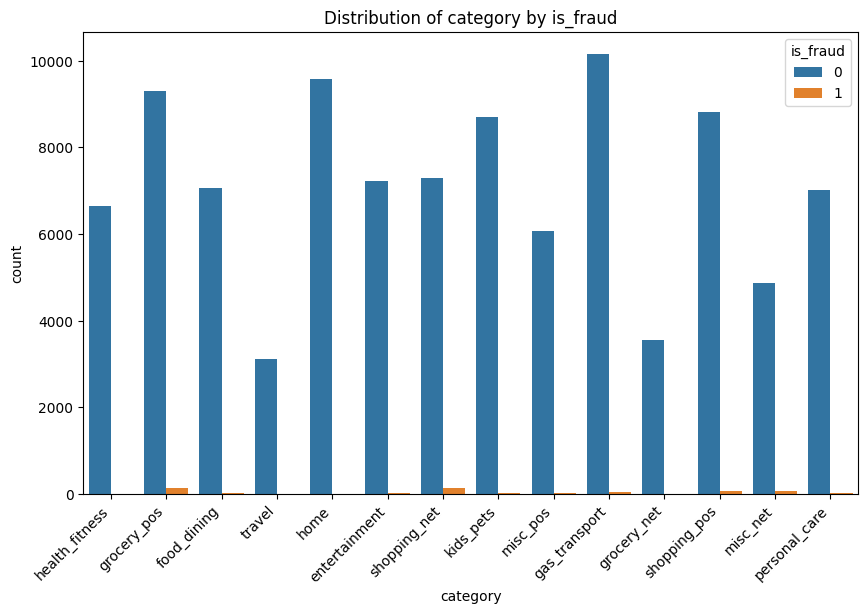

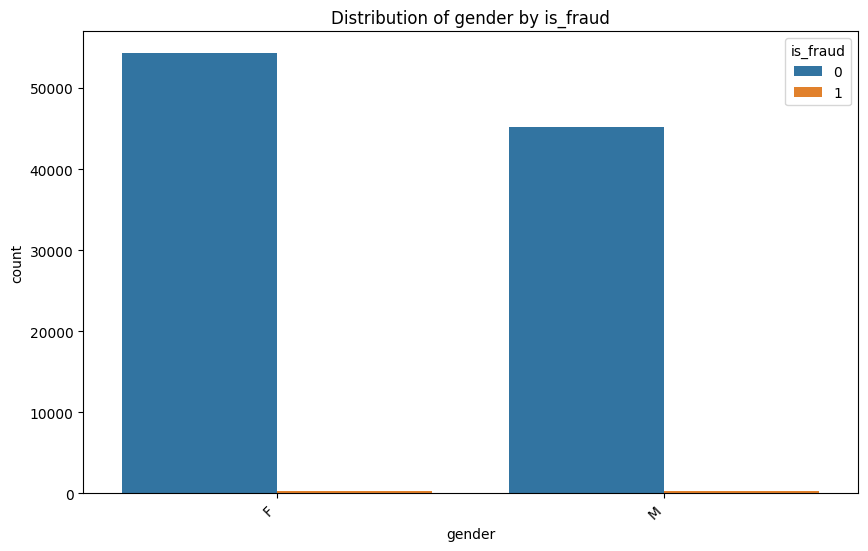

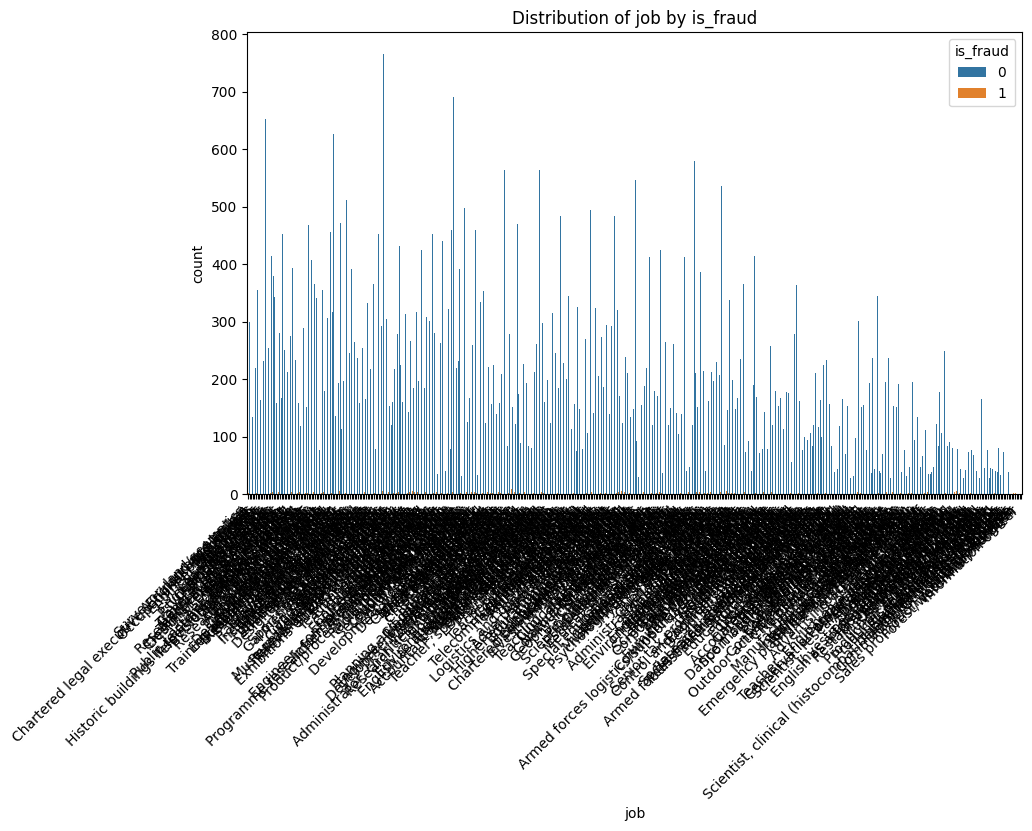

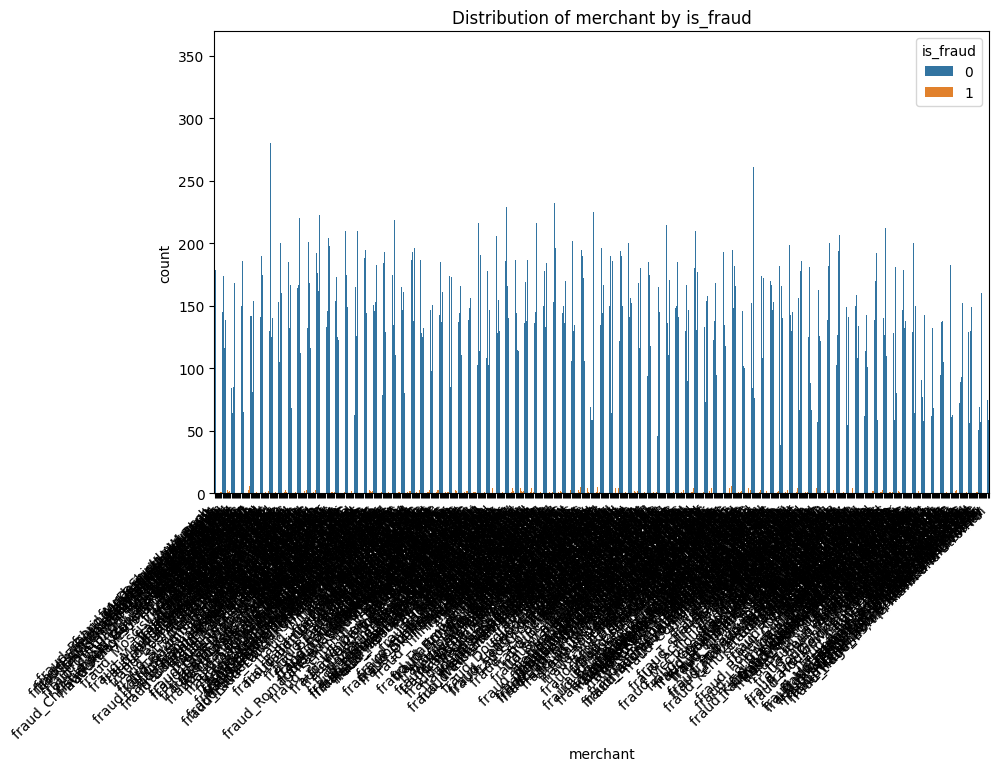

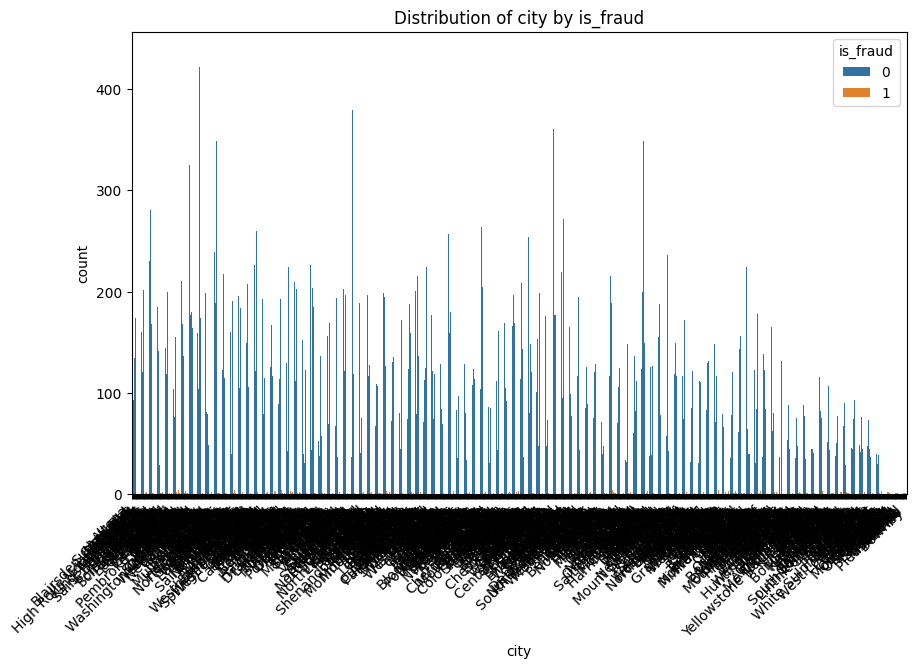

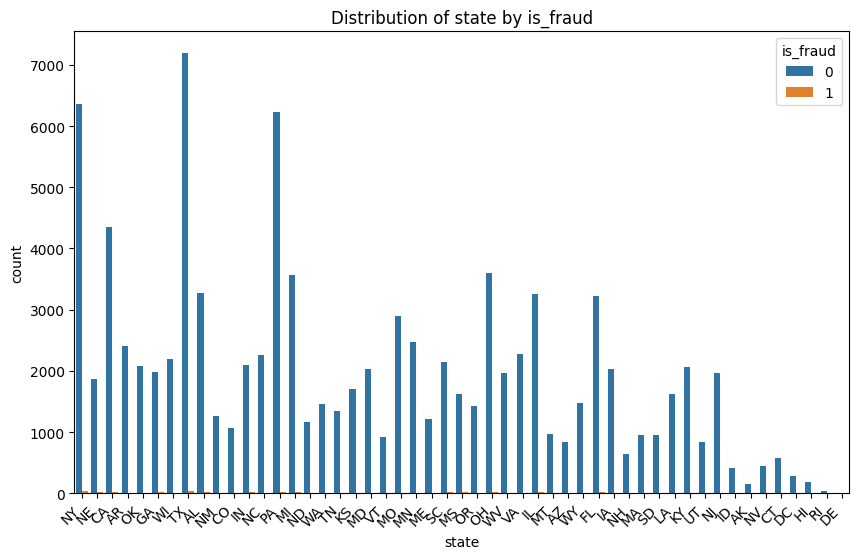

In [13]:

# List of categorical variables
categorical_vars = ['category', 'gender', 'job', 'merchant', 'city', 'state']

# Plot distribution of categorical variables by 'is_fraud'
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fraud_train_reduced, x=var, hue='is_fraud')
    plt.title(f'Distribution of {var} by is_fraud')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.show()


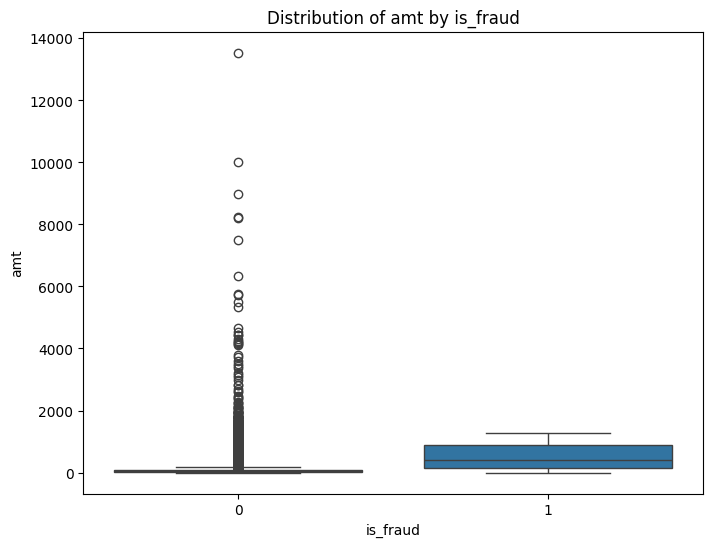

In [60]:
#Looking at distribution of amount by whether it is fraud or not..
plt.figure(figsize=(8, 6))
sns.boxplot(data=fraud_train_reduced, x='is_fraud', y='amt')
plt.title(f'Distribution of amt by is_fraud')
plt.show()


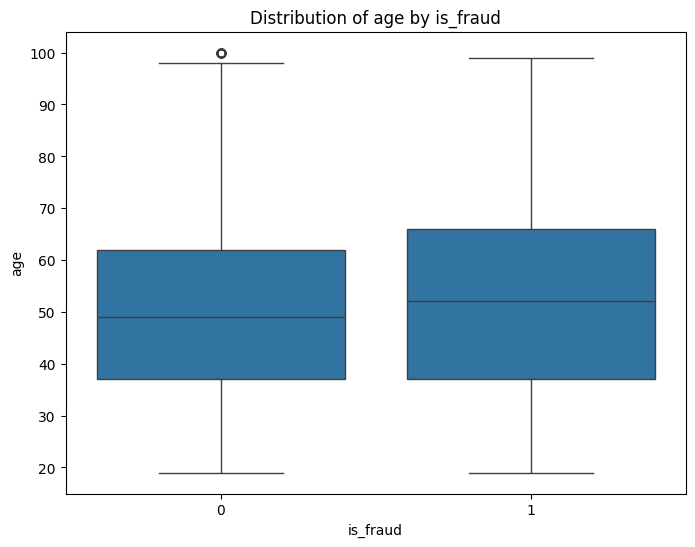

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=fraud_train_reduced, x='is_fraud', y='age')
plt.title(f'Distribution of age by is_fraud')
plt.show()

I am just curious about the breakdown for some of the categorical features, especially on the gender and the merchant categories. I believe the distribution of some of these categorical fields are quite highly skewed.

It is really HARD to get a proper visuals from these graph, especially for the categorical features, but you can indeed observe quite alot of outliers with *amt* field and those that commited fraud is seemingly on the lower end of the fraud spectrum...Perhaps *smaller* the amount, the easier to sneak it through and past any security trigger..On a side note, i do not see any major difference between those who commit fraud vs those who didn't for age variable. Might be the case that age  not being a strong predictor of *fraud*

In [13]:
#let us start separating the data into x & y
X = fraud_train_reduced.drop(columns=['is_fraud'],axis=1)
y = fraud_train_reduced['is_fraud']
print(X.shape)
print(y.shape)

(100000, 8)
(100000,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 8)
(30000, 8)
(70000,)
(30000,)


In [15]:
# Count the number of occurrences of each class in y_train
y_train_counts = np.bincount(y_train)
y_test_counts = np.bincount(y_test)

# Display the counts
print(f'y_train counts: 0 -> {y_train_counts[0]}, 1 -> {y_train_counts[1]}')
print(f'y_test counts: 0 -> {y_test_counts[0]}, 1 -> {y_test_counts[1]}')

y_train counts: 0 -> 69595, 1 -> 405
y_test counts: 0 -> 29826, 1 -> 174


In [16]:
num_columns = X.select_dtypes(include=['float64','int64']).columns
cat_columns = X.select_dtypes(include=['object']).columns
print(num_columns)
print(cat_columns)

Index(['amt', 'age'], dtype='object')
Index(['category', 'gender', 'job', 'merchant', 'city', 'state'], dtype='object')


### creating the pre processing pipelines - these are important!

In [17]:
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse_output=False))
num_transformer = make_pipeline(MinMaxScaler())

preprocessor = make_pipeline(ColumnTransformer([('num_transformer',num_transformer,num_columns),('cat_transformer',cat_transformer,cat_columns)],
                                               remainder='passthrough'))

In [18]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(70000, 2106)
(30000, 2106)


In [19]:
# Instantiate the logistic regression model
LR_model = LogisticRegression(random_state=123)

# Fit the model on the training data
LR_model.fit(X_train, y_train)

# Make predictions on the test data
LR_pred = LR_model.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, LR_pred)
print(f'accuracy: {accuracy:.4f}')
recall = recall_score(y_test, LR_pred)
print(f'Recall for fraud cases: {recall:.4f}')
precision = precision_score(y_test, LR_pred)
print(f'Precision for fraud cases: {precision:.4f}')
cf_matrix = confusion_matrix(y_test, LR_pred)
print(cf_matrix)

accuracy: 0.9940
Recall for fraud cases: 0.0000
Precision for fraud cases: 0.0000
[[29821     5]
 [  174     0]]


In [22]:
fraud_train_reduced['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.99421
1    0.00579
Name: proportion, dtype: float64

Logistic regression out of the box is horrendous..don't be *deceived* by the high accuracy rate because more than 99% of the cases are negative cases. So the logistic regression model is only predicting those cases..

In [26]:
# Instantiate the model and use all available processors
RF_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=123)

#Fitting the random forest model on the training data
RF_model.fit(X_train, y_train)

#Making predictions on the test data
RF_pred = RF_model.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test, RF_pred)
print(f'accuracy: {accuracy:.4f}')
recall = recall_score(y_test, RF_pred)
print(f'Recall for fraud cases: {recall:.4f}')
precision = precision_score(y_test, RF_pred)
print(f'Precision for fraud cases: {precision:.4f}')
cf_matrix = confusion_matrix(y_test, RF_pred)
print(cf_matrix)

accuracy: 0.9954
Recall for fraud cases: 0.2356
Precision for fraud cases: 0.8723
[[29820     6]
 [  133    41]]


Random forest is already performing better here..Out of the actual postives cases in the test set, it is able to get 23.5% right.

In [21]:
#Xgboost model
XGBmodel = XGBClassifier(random_state=123, n_jobs=-1)
XGBmodel.fit(X_train, y_train)

XGB_pred = XGBmodel.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, XGB_pred)
print(f'accuracy: {accuracy:.4f}')
recall = recall_score(y_test, XGB_pred)
print(f'Recall for fraud cases: {recall:.4f}')
precision = precision_score(y_test, XGB_pred)
print(f'Precision for fraud cases: {precision:.4f}')
cf_matrix = confusion_matrix(y_test, XGB_pred)
print(cf_matrix)

accuracy: 0.9968
Recall for fraud cases: 0.5977
Precision for fraud cases: 0.8062
[[29801    25]
 [   70   104]]


This is already proving to be much better! Extreme gradient boosting is able to get ~ 60% of true fradulent cases right in the test set!

In [23]:
# Define the parameter distribution

param_dist = {
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 300)
}

# Initialize the model
XGBmodel = XGBClassifier(random_state=123, n_jobs=-1)

# Set up the Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=XGBmodel, param_distributions=param_dist, n_iter=20, cv=4, scoring='recall', verbose=1, n_jobs=-1, random_state=123)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation recall: {random_search.best_score_:.4f}")

Fitting 4 folds for each of 20 candidates, totalling 80 fits


I couldn't even get random search to run..so I am unable to optimize my hyperparameters as I kept running out of memory. Colab runtime also kept getting disconnected although I am using colab PRO. So for now, I will stick with not fine tuning the model.

So most performant model is XGboost as of now - with recall of ~ 60%

In [3]:
import os
os.getcwd()

'/Users/eugenechua/Downloads/Fraud_Analysis_AWS/notebooks'

In [11]:
fraud_test = pd.read_csv('../data/inference/fraud_test.csv')
fraud_test.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
0,2020-11-10 19:52:39,4.158760e+15,fraud_Schulist Ltd,food_dining,172.21,Dawn,Cox,F,193 Catherine Ways,Hills,...,56138,43.5335,-96.3645,899,Data scientist,1995-01-15,eaa867a6434a4d074edc9a794b48b2a1,1384113159,44.306106,-95.541626
1,2020-07-17 13:48:53,4.908850e+15,fraud_Erdman-Schaden,personal_care,31.88,Lauren,Torres,F,03030 White Lakes,Grandview,...,76050,32.2779,-97.2351,5875,"Radiographer, therapeutic",1992-07-24,c5d2b7306c90cee7b0e22009f480533f,1374068933,31.378934,-97.666683
2,2020-12-28 19:06:46,3.599240e+15,fraud_Osinski Inc,personal_care,11.76,Jessica,Smith,F,06808 Ryan Valleys,Dubre,...,42731,36.8421,-85.5396,341,Insurance risk surveyor,1932-11-19,95ddfc0cec6feb110a3fc224f4eaa857,1388257606,37.755207,-85.816593
3,2020-10-21 16:56:10,2.227670e+15,fraud_Lubowitz-Walter,kids_pets,100.44,Angie,Jones,F,6970 Blake Trail,Clearwater,...,33760,27.9004,-82.7152,172247,"Geneticist, molecular",1979-10-22,c260383b949784e814a4f4058e874b6b,1382374570,27.884504,-82.733450
4,2020-12-01 13:58:34,3.549200e+15,"fraud_Lang, Towne and Schuppe",kids_pets,29.52,Larry,Williams,M,6274 David Oval Suite 725,Scarborough,...,4074,43.5835,-70.3457,18760,Make,1933-04-02,0575b4cc64d0f7791e57a5616e01fdbd,1385906314,44.442056,-70.835171


In [12]:
def calculate_age(born):
    today = datetime.today()
    return int(today.year - born.year)

In [13]:
fraud_test['dob'] = pd.to_datetime(fraud_test['dob'], format='%Y-%m-%d')
#Calculating for the age variable
fraud_test['age'] = fraud_test['dob'].apply(calculate_age)

# Now lets select columns that I think are possibly useful
selectedcolumns = ['category','amt','gender','job','merchant', 'city', 'state', 'age']
fraud_test= fraud_test[selectedcolumns]

In [14]:
   #Selecting the numerical and categorical columns for easy preprocessing!
num_columns = fraud_test.select_dtypes(include=['float64','int64']).columns
cat_columns = fraud_test.select_dtypes(include=['object']).columns

     #Creating the preprocessing pipelines!
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse_output=False))
num_transformer = make_pipeline(MinMaxScaler())

preprocessor = make_pipeline(ColumnTransformer([('num_transformer',num_transformer,num_columns),('cat_transformer',cat_transformer,cat_columns)],
                                               remainder='passthrough'))

In [15]:
fraud_test = preprocessor.fit_transform(fraud_test)
fraud_test.shape

(100, 317)